# Introduction

This experiment is to test the linear-to-spherical warping algorithm. This warping is also called as rectilinear-to-equirectangular transform.

The experiments uses the transformation formula described in the blog <a href='http://blog.nitishmutha.com/equirectangular/360degree/2017/06/12/How-to-project-Equirectangular-image-to-rectilinear-view.html'>How to map Equirectangular projection to Rectilinear projection</a>.


In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import cv2 as cv
from math import pi
import numpy as np
import matplotlib.pyplot as plt

from libpano import MetaData
from libpano import utils
from libpano import warpers

In [3]:
ID = 'recent-04'
IMAGE_FOLDER = '../images/' + ID + '/'
JSON_FN = IMAGE_FOLDER + ID + '.json'

meta_data = MetaData.MetaData(IMAGE_FOLDER)
metrics = meta_data.metrics
meta = meta_data.grid_data

print(metrics)

Camera Metrics:
	Focal Length: 4.4589 mm
	Focal Length: 1588.26 px
	Sensor Size: 4.2447996 x 5.6447997 mm
	Pixels per mm: 356.20 x 357.14 px
PanoramaMetrics:
	Frame Count: 15 x 5
	Frame Size: 1512px x 2016px
	Interval Angle: 24.0︒ x 36.0︒
	AoV: 50.9081︒ x 64.6661︒
	AoV: 0.8885 x 1.1286
	PPR: 1701.7168px x 1786.2268px
	Panorama Size: 10692.2019px x 5611.5971px



In [4]:
frame_id = 50

row = meta.iloc[frame_id]
uri = row.uri
pitch = utils.degree2radian(row.pitch)
yaw = utils.degree2radian(row.yaw)
print(pitch, yaw)
row

0.6204308467803892 2.390950872946751


row                   3
col                   5
uri      img-r4-0-1.jpg
pitch           35.5481
roll           -1.58718
yaw             136.991
Name: 50, dtype: object

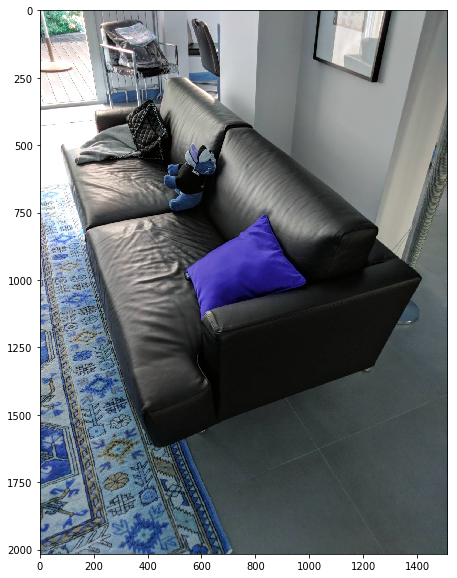

In [5]:
image = cv.imread(IMAGE_FOLDER + uri)

plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.show()

# Rectilinear to Equerectangular

In [6]:
PI = pi
PI2 = 2 * pi
PI_2 = pi * 0.5

height, width, channel = image.shape

### Source map

In [7]:
xx, yy = np.meshgrid(np.linspace(0, width-1, width), np.linspace(0, height-1, height))
xx = xx.ravel().astype(int)
yy = yy.ravel().astype(int)
source_map = np.array([xx, yy]).T


### Destination map

In [8]:
lam0 = 0
phi1 = pitch + PI_2

cx = width / 2
cy = height / 2

d_lambda = (xx - cx) / metrics.PPR_h  # lambda - lambda0
phi = (yy - cy) / metrics.PPR_v

print('d_lambda: {} ~ {}\nphi: {} ~ {}'.format(np.min(d_lambda), np.max(d_lambda), np.min(phi), np.max(phi)))

cos_c = np.sin(phi1) * np.sin(phi) + np.cos(phi1) * np.cos(phi) * np.cos(d_lambda)

x = np.cos(phi) * np.sin(d_lambda) / cos_c
y = (np.cos(phi1) * np.sin(phi) - np.sin(phi1) * np.cos(phi) * np.cos(d_lambda)) / cos_c

print('X: {} ~ {}\nY: {} ~ {}'.format(np.min(x), np.max(x), np.min(y), np.max(y)))

x = metrics.PPR_h * (x + PI)
y = metrics.PPR_v * (y + PI_2)

print('X: {} ~ {}\nY: {} ~ {}'.format(np.min(x), np.max(x), np.min(y), np.max(y)))
x = x /100
y = y / 100

x = x.astype(int)
y = y.astype(int)
x = x - np.min(x)
y = y - np.min(y)

print('X: {} ~ {}\nY: {} ~ {}'.format(np.min(x), np.max(x), np.min(y), np.max(y)))

destination_map = np.array([x, y]).T
destination_map.shape

d_lambda: -0.4442572383323471 ~ 0.4436695964827011
phi: -0.5643180256859903 ~ 0.5637581863747939
X: -40.02765304949088 ~ 40.63315223664356
Y: 0.35255426423971964 ~ 104.20468189497554
X: -62769.62816403211 ~ 74492.21820502818
Y: 3435.5404355658243 ~ 188938.99750576683
X: 0 ~ 1371
Y: 0 ~ 1855


(3048192, 2)

In [9]:
new_width = int(x.max()) + 1
new_height = int(y.max()) + 1

warped = np.zeros((new_height, new_width, 3), np.uint8)

for idx, dst in enumerate(destination_map):
    src = source_map[idx]
    warped[int(dst[1]), int(dst[0])] = image[int(src[1]), int(src[0])]

warped = cv.remap(image, destination_map, source_map, cv.INTER_LINEAR, borderMode=cv.BORDER_CONSTANT, borderValue=(0, 0, 0) )

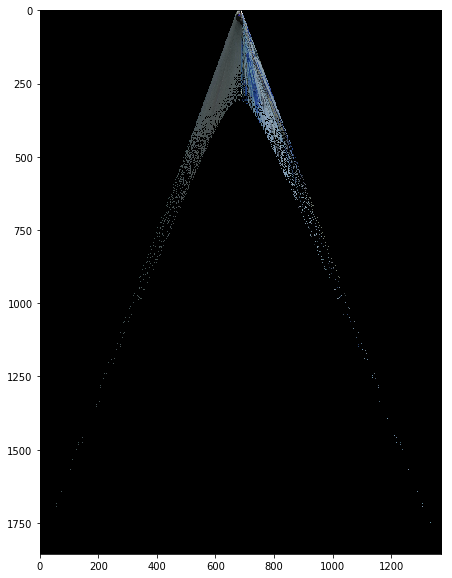

In [10]:
plt.figure(figsize=(10, 10))
plt.imshow(warped)
plt.show()

### Awful!

# Inverse Equirectangular-rectilinear projection

Rectilinear-to-equirectangular tranformation has failed. So I tried to perform equirectangular-rectilinear transform and inverse it.

This algorithm was implemented in the libpano.warpers package.

In [11]:
warped, mask = warpers.spherical_warp(image, pitch, metrics)

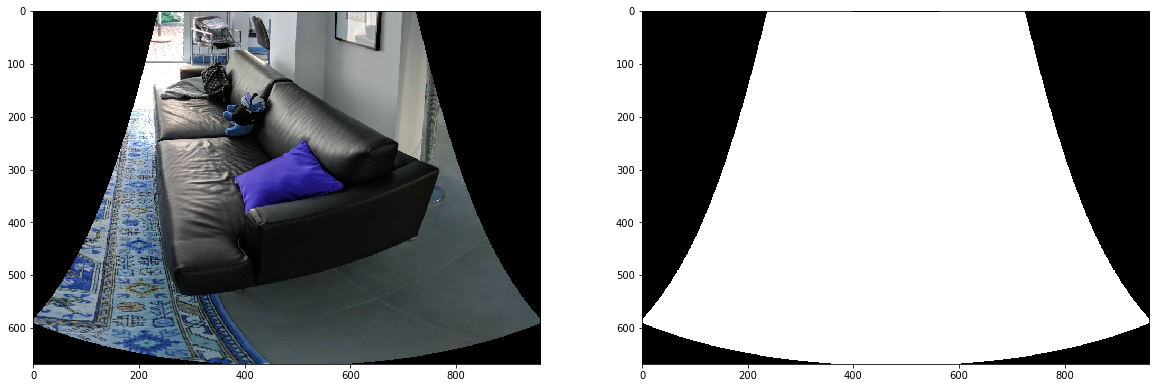

In [12]:
_, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(warped)
ax[1].imshow(mask)
plt.show()

#### It works well just now...

Now, let's test this spherical warper in various conditions.

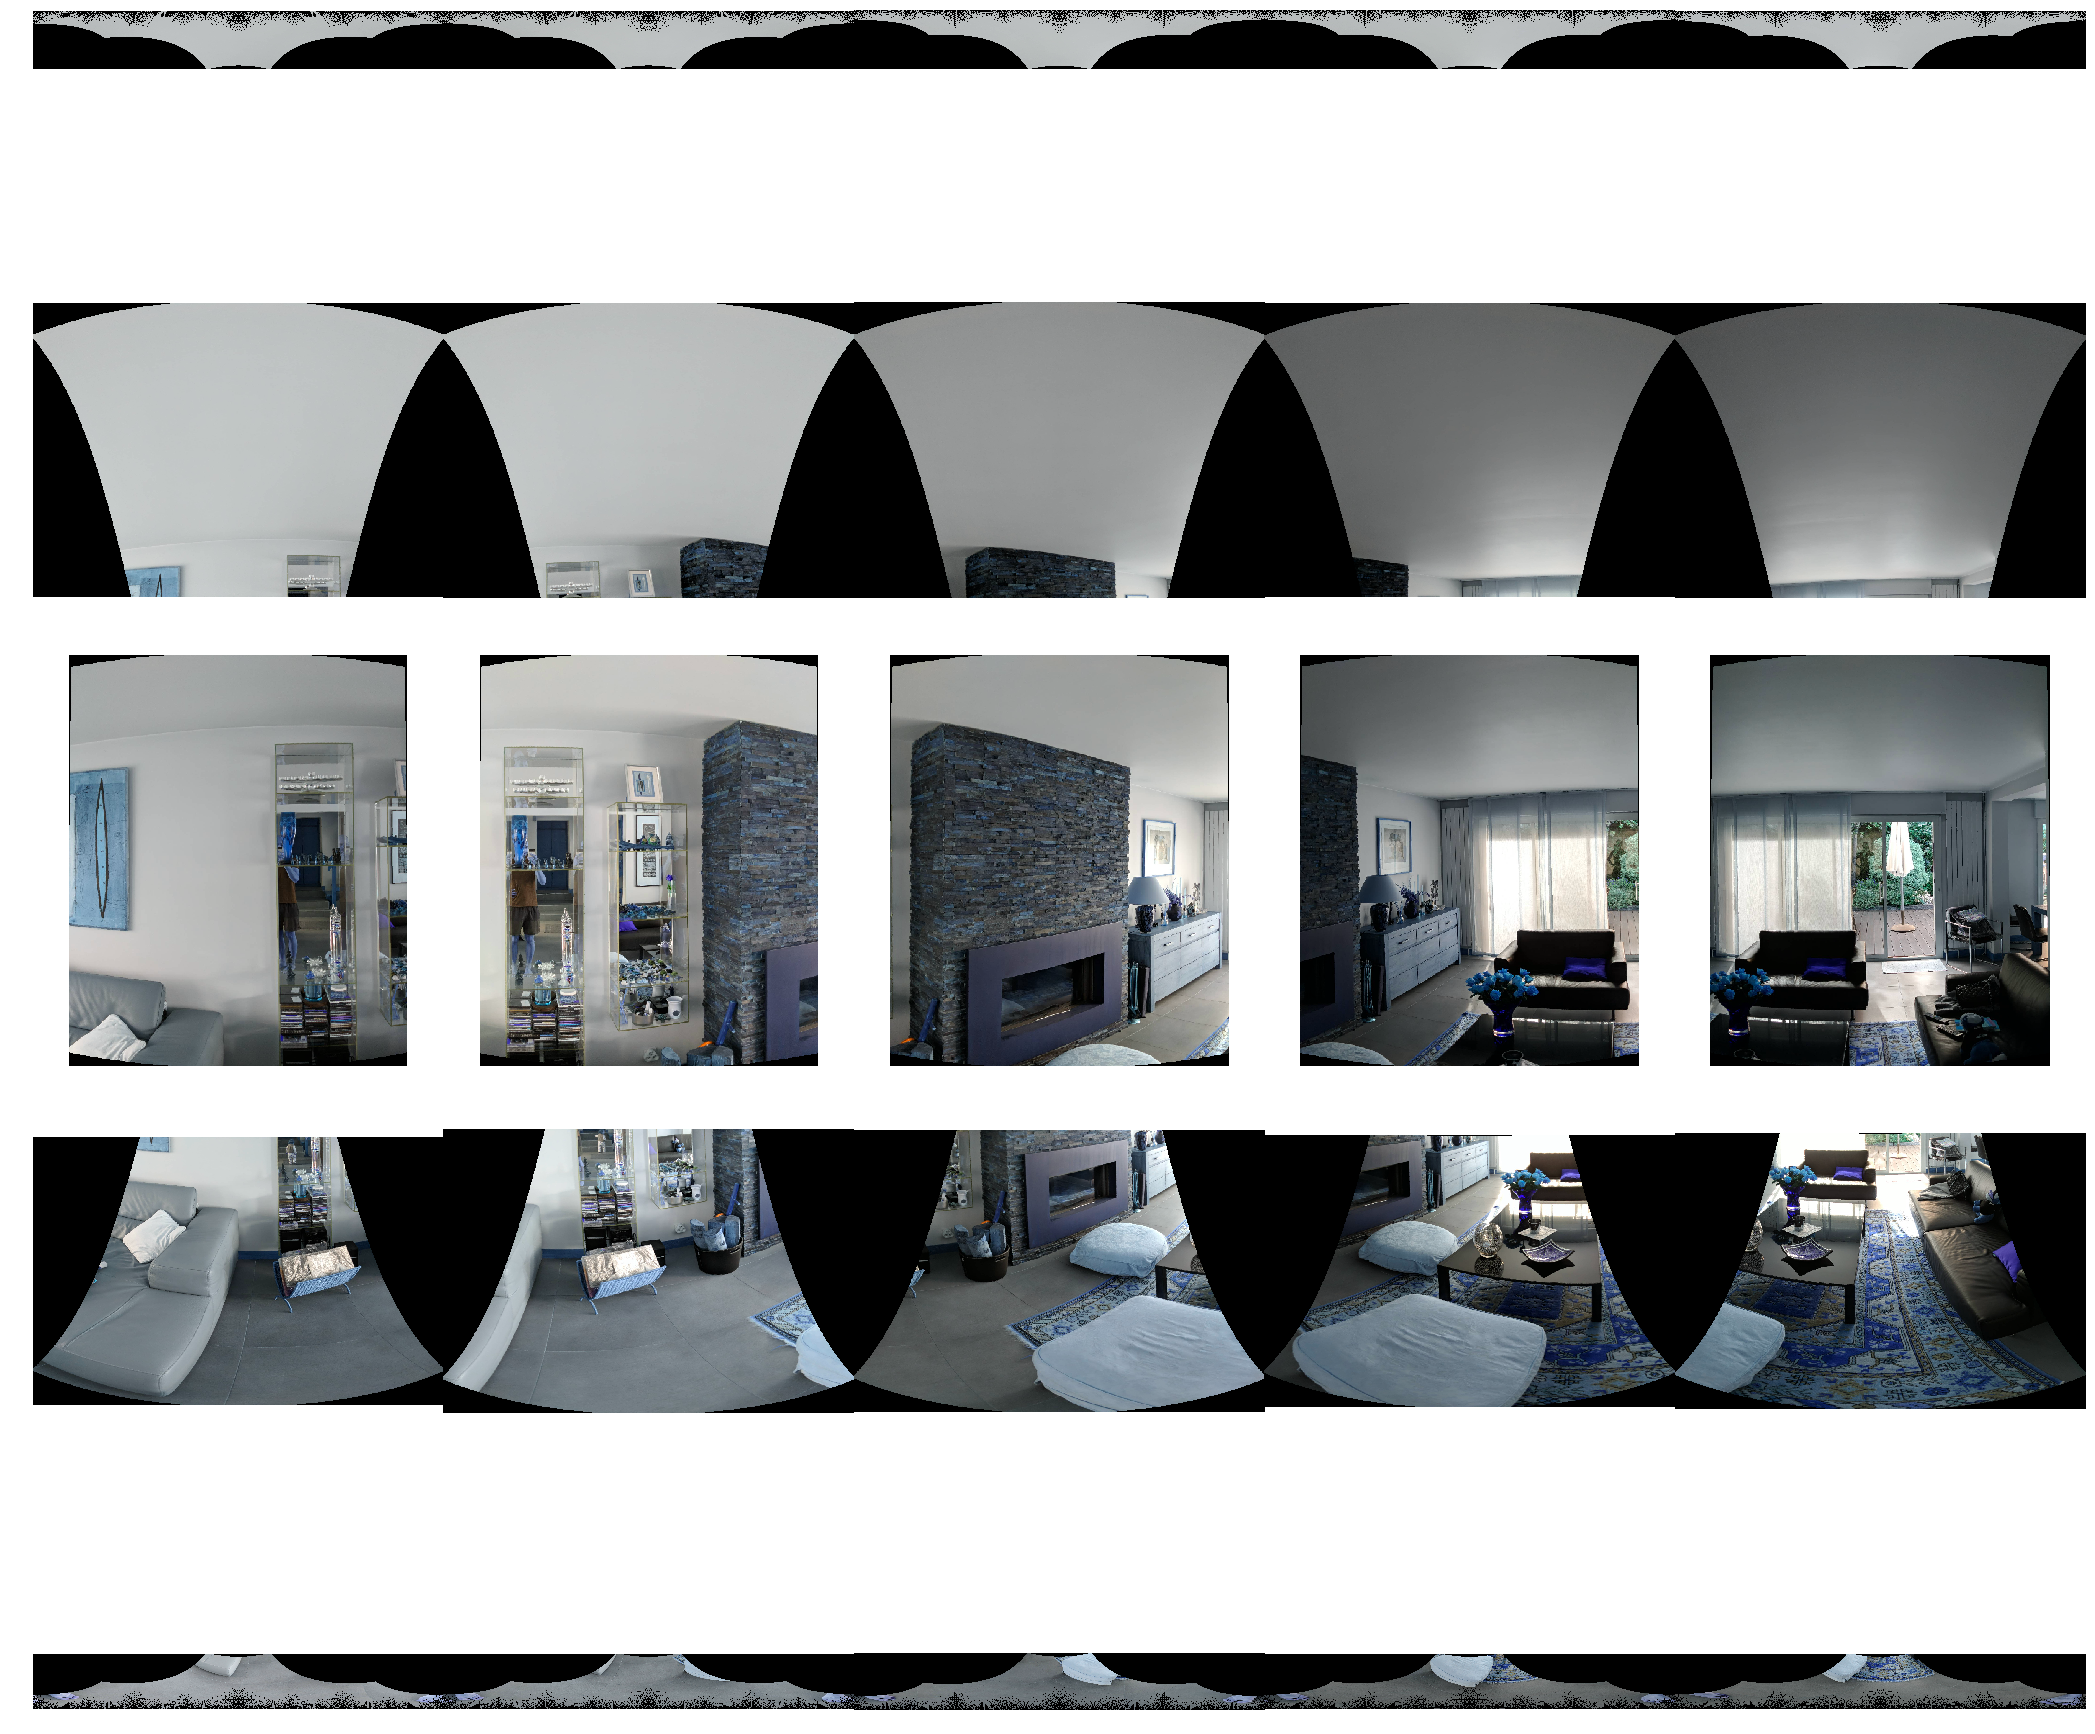

In [13]:
_, ax = plt.subplots(5, 5, figsize=(30, 30))
plt.subplots_adjust(0, 0, 0.95, 0.95, 0, 0)

for row in range(5):
    
    for col in range(5):
        # read & convert color system
        record = meta.loc[(meta.row==row)&(meta.col==col)]
        fn = record.uri.values[0]
        pitch = record.pitch.values[0]
        
        img = cv.imread(IMAGE_FOLDER + fn)

        img, _ = warpers.spherical_warp(img, utils.degree2radian(pitch), metrics)
        cv.imwrite('warped-{}-{}.jpg'.format(row, col), img)
        ax_cur = ax[row][col]
        ax_cur.imshow(img)
        ax_cur.axis('off')
        
        del img
        
plt.show()

# Conclusion

1. #### Spherical warping works well but it needs more tunning : interpolcation.
1. #### Warped images need more process such as rotation and scaling. 
    I measured the sizes of vertically adjacent images and found that their width in the overlapping area are little different.